<a href="https://colab.research.google.com/github/microprediction/microprediction/blob/master/The_Signal_And_The_Nate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
nate = pd.read_csv('https://projects.fivethirtyeight.com/2020-general-data/presidential_state_toplines_2020.csv')
latest = nate.loc[nate['modeldate']=='11/3/2020',:]
trump = latest[['state','winstate_inc']]
nate = dict(zip(trump['state'].values,trump['winstate_inc'].values))

In [10]:
predictit_swing = {'Arizona':0.43,'Iowa':0.63,'Georgia':0.57,'Florida':0.58,'Minnesota':0.25,
            'New Hampshire':0.21,'Pennsylvania':0.38,'North Carolina':0.47,'Texas':0.71,
            'Michigan':0.30,'Wisconsin':0.28,'Ohio':0.68,'Alaska':0.88}
trump = {'Arizona':0,'Iowa':1,'Georgia':0.04,'Florida':1,'Minnesota':0,
            'New Hampshire':0,'Pennsylvania':0,'North Carolina':0.94,'Texas':1,
            'Michigan':0,'Wisconsin':0,'Ohio':1,'Alaska':1}



In [11]:
nate_swing = dict([(s,p) for s,p in nate.items() if s in predictit_swing])
nate_brier = [ (p-trump[s])**2 for s,p in nate_swing.items() ]
predictit_brier = [ (p-trump[s])**2 for s,p in predictit_swing.items() ]
math.sqrt(np.mean(nate_brier)),math.sqrt(np.mean(predictit_brier))

(0.35474296511428793, 0.3530417277581526)

Text(0, 0.5, 'Brier score')

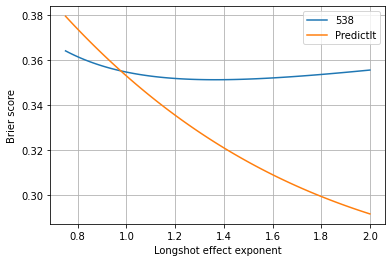

In [14]:
import math
def adjusted_brier(expon,predictions,result):
   fixed = dict([(s,p**expon/(p**expon+(1-p)**expon)) for s,p in predictions.items()])
   return math.sqrt(np.mean([ (p-result[s])**2 for s,p in fixed.items() ]))
import numpy as np
expons =  np.linspace(0.75,2,100)
pi_briers = [ adjusted_brier(expon,predictit_swing,trump) for expon in expons]
nate_briers = [ adjusted_brier(expon,nate_swing,trump) for expon in expons]
import matplotlib.pyplot as plt
plt.plot(expons,nate_briers,expons,pi_briers)
plt.grid()
plt.legend(['538','PredictIt'])
plt.xlabel('Longshot effect exponent')
plt.ylabel('Brier score')


Text(0, 0.5, 'Negative Log-Likelihood')

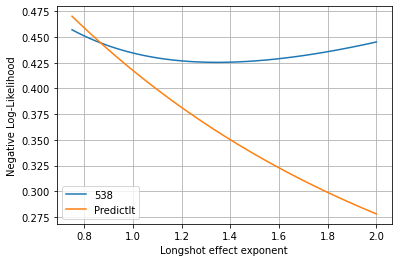

In [137]:
import math
def adjusted_loglike(expon,predictions,result):
   fixed = dict([(s,p**expon/(p**expon+(1-p)**expon)) for s,p in predictions.items()])
   return -np.mean([ math.log(p) if result[s] else math.log(1-p) for s,p in fixed.items() ])
expons =  np.linspace(0.75,2,100)
pi_ll = [ adjusted_loglike(expon,predictit_swing,trump_more) for expon in expons]
nate_ll = [ adjusted_loglike(expon,nate_swing,trump_more) for expon in expons]
plt.plot(expons,nate_ll,expons,pi_ll)
plt.grid()
plt.legend(['538','PredictIt'])
plt.xlabel('Longshot effect exponent')
plt.ylabel('Negative Log-Likelihood')

In [151]:
adjusted_loglike(1,predictit_swing,trump_more),adjusted_loglike(1,nate_swing,trump_more)

(0.4175868026706624, 0.4345285761879868)

In [121]:
comparison = [ (s,trump[s],predictit_swing[s],nate_swing[s]) for s in trump]
comparison

[('Arizona', 0, 0.43, 0.319775),
 ('Iowa', 1, 0.63, 0.6013),
 ('Georgia', 0.04, 0.57, 0.418475),
 ('Florida', 1, 0.58, 0.309),
 ('Minnesota', 0, 0.25, 0.0419),
 ('New Hampshire', 0, 0.21, 0.10915),
 ('Pennsylvania', 0, 0.38, 0.1569),
 ('North Carolina', 0.94, 0.47, 0.360675),
 ('Texas', 1, 0.71, 0.617525),
 ('Michigan', 0, 0.3, 0.053175),
 ('Wisconsin', 0, 0.28, 0.056425),
 ('Ohio', 1, 0.68, 0.546725),
 ('Alaska', 1, 0.88, 0.8505)]

In [112]:
errors = [ (s,trump[s]-predictit_swing[s],trump[s]-nate_swing[s]) for s in trump]
errors

[('Arizona', -0.43, -0.319775),
 ('Iowa', 0.37, 0.39870000000000005),
 ('Georgia', -0.5299999999999999, -0.378475),
 ('Florida', 0.42000000000000004, 0.6910000000000001),
 ('Minnesota', -0.25, -0.0419),
 ('New Hampshire', -0.21, -0.10915),
 ('Pennsylvania', -0.38, -0.1569),
 ('North Carolina', 0.47, 0.5793249999999999),
 ('Texas', 0.29000000000000004, 0.382475),
 ('Michigan', -0.3, -0.053175),
 ('Wisconsin', -0.28, -0.056425),
 ('Ohio', 0.31999999999999995, 0.453275),
 ('Alaska', 0.12, 0.14949999999999997)]

## Adding more states 

In [7]:
predictit_more = {'California':0.06,'Washington':0.06,'Oregon':0.097,
                  'North Dakota':0.96,'South Dakota':0.97,'Nebraska':0.97,
                  'Kansas':0.96,'Virginia':0.07,'Mississippi':0.94,'Louisiana':0.97}
trump_more = {'California':0,'Washington':0,'Oregon':0,
              'North Dakota':1,'South Dakota':1,'Nebraska':1,'Kansas':1,
              'Virginia':0,'Mississippi':1,'Louisiana':1}
predictit_more.update(predictit_swing)
trump_more.update(trump)
trump_more



{'Alaska': 1,
 'Arizona': 0,
 'California': 0,
 'Florida': 1,
 'Georgia': 0.04,
 'Iowa': 1,
 'Kansas': 1,
 'Louisiana': 1,
 'Michigan': 0,
 'Minnesota': 0,
 'Mississippi': 1,
 'Nebraska': 1,
 'New Hampshire': 0,
 'North Carolina': 0.94,
 'North Dakota': 1,
 'Ohio': 1,
 'Oregon': 0,
 'Pennsylvania': 0,
 'South Dakota': 1,
 'Texas': 1,
 'Virginia': 0,
 'Washington': 0,
 'Wisconsin': 0}

Text(0, 0.5, 'Brier score')

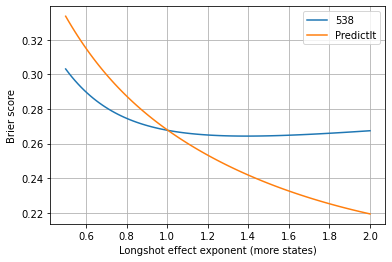

In [15]:
nate_more = dict([(s,p) for s,p in nate.items() if s in predictit_more])

# Does it make a difference??

expons =  np.linspace(0.5,2,100)
pi_briers = [ adjusted_brier(expon,predictit_more,trump_more) for expon in expons]
nate_briers = [ adjusted_brier(expon,nate_more,trump_more) for expon in expons]
import matplotlib.pyplot as plt
plt.plot(expons,nate_briers,expons,pi_briers)
plt.grid()
plt.legend(['538','PredictIt'])
plt.xlabel('Longshot effect exponent (more states)')
plt.ylabel('Brier score')